In [92]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import math as m
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [93]:
pt_path = '../Data/ML/2024-04-23/pt/50/model_epoch_399.pt'
input_path = "../Data/concat_data/track_data1.csv"
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('CUDA is available')
else:
    print('No CUDA, using CPU')
    device = torch.device('cpu')


CUDA is available


In [94]:
class EstimationLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_len, num_layers):
        super(EstimationLSTM, self).__init__()
        self.seq_len = seq_len
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        # LSTM layer followed by a fully connected layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through LSTM and fully connected layer


        out, _ = self.lstm(x)
        out = self.fc1(out[:, -1])
        out = self.fc2(out)
 
        return out

    def reset_hidden_state(self):
        # Reset hidden state of the LSTM
        self.hidden = (
            torch.zeros(self.num_layers, self.seq_len, self.hidden_size),
            torch.zeros(self.num_layers, self.seq_len, self.hidden_size)
        )

In [95]:
def normalization(data,min_val,max_val):
        # Normalize the input data
        data_shape = data.shape
        data = np.reshape(data,(-1,data.shape[-1]))

        min_value = np.zeros(shape = np.size(min_val))
        max_value = np.ones(shape = np.size(max_val))
        scaled_data = min_value + (max_value - min_value) * (data - min_val) / (max_val - min_val)

        negative_indices = scaled_data < 0
        scaled_data[negative_indices] = 0

        over_indices = scaled_data > 1
        scaled_data[over_indices] = 1

        scaled_data = np.reshape(scaled_data,data_shape)
        
        return scaled_data
        
        
def denormalization(scaled_data,y_min_value,y_max_value):

        min_val = y_min_value
        max_val = y_max_value

        denormalized_data = min_val + (max_val - min_val) * (scaled_data)

        return denormalized_data

In [96]:
# Data import
x_min_value =  np.array([-0.6, 0, 0, 0, 0, -30, -1, -2, 0])
y_min_value = np.array([-4000])
x_max_value =  np.array([0.6, 30, 30, 30, 30, 30, 1, 2, 35])
y_max_value = np.array([4000])

data = pd.read_csv(input_path)
y = data.pop(str(data.columns[-1])).values
data = data.values
data_X = []
data_Y = []
for i in range(0, len(data) - 200):
                _x = data[i:i + 200, :]
                _y = np.array([y[i + 200-1]])
                data_X.append(_x)
                data_Y.append(_y)

# Data normailzaition
data_X = np.array(data_X)
data_Y = np.array(data_Y)
data_Y = normalization(data_Y,y_min_value,y_max_value)
data_X = normalization(data_X,x_min_value,x_max_value)

data_tensor = torch.tensor(data_X, dtype=torch.float32)

In [97]:
model_pt = torch.load(pt_path)
model_pt.eval()


EstimationLSTM(
  (lstm): LSTM(9, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)

In [104]:
data_tensor=data_tensor.to(device=device)
model_pt = model_pt.to(device=device)

with torch.no_grad():
    outputs = []
    for x in data_tensor:
        x = x.unsqueeze(0)
        output = model_pt(x)
        outputs.append(output.to('cpu'))

outputs = denormalization(outputs,y_min_value,y_max_value)


In [120]:
print(y.shape)
print(outputs.shape)

(49892,)
(49692, 1, 1)


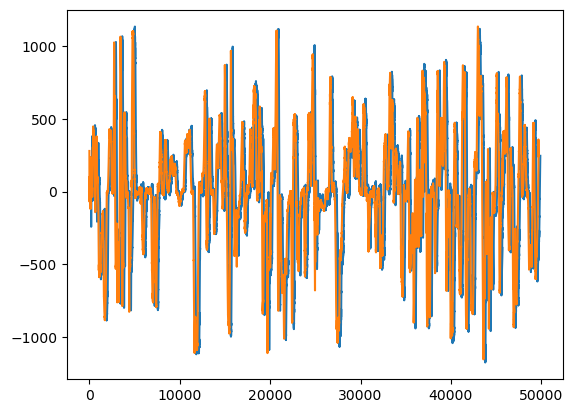

In [123]:
plt.plot(y.reshape(-1,1))
plt.plot(outputs.reshape(-1,1))